### Training on the other Boolean functions

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
# Generating n-bit numbers
def generate_n_bit_numbers(n):
    return [list(map(int, bin(i)[2:].zfill(n))) for i in range(2**n)]

x_2_list = generate_n_bit_numbers(2)
x_4_list = generate_n_bit_numbers(4)
x_5_list = generate_n_bit_numbers(5)

x_2 = np.array(x_2_list)
x_4 = np.array(x_4_list)
x_5 = np.array(x_5_list)

In [4]:
# XOR function
def xor_function(x):
    y = [int(np.bitwise_xor.reduce(seq)) for seq in x]
    return y

# Palindrome function
def palindrome_function(x):
    y = [int(seq == seq[::-1]) for seq in x]
    return y

# Even Parity function
def even_parity_function(x):
    y = [int(sum(seq) % 2 == 0) for seq in x]
    return y

x_2_xor_y = np.array(xor_function(x_2_list))

x_4_palindrome_y = np.array(palindrome_function(x_4_list))
x_5_palindrome_y = np.array(palindrome_function(x_5_list))

x_4_even_parity_y = np.array(even_parity_function(x_4_list))
x_5_even_parity_y = np.array(even_parity_function(x_5_list))

In [5]:
# Activation functions and their derivatives
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(a):
    return a * (1 - a)      # Here, a[i] = sigmoid(z[i])

def relu(x):
    return np.maximum(0, x)

def relu_derivative(a):
    return np.where(a > 0, 1, 0)    # Here, a[i] = relu(z[i])

# Loss functions and their derivatives
def mse(y, y_hat):
    assert(y.shape == y_hat.shape)
    return np.mean((y - y_hat)**2)

def bce(y, y_hat):
    assert(y.shape == y_hat.shape)
    return -np.mean(y * np.log(y_hat) + (1 - y) * np.log(1 - y_hat))

In [6]:
# Neural Network class with all activation functions being sigmoid
class SigmoidNN:
    def __init__(self, arch, x, y, lr=0.1, epochs=1000, loss_func="bce"):
        self.arch = arch
        self.x = x
        self.no_of_samples = x.shape[0]  # M samples
        self.y = y
        
        if len(y.shape) == 1:
            self.y = y.reshape(-1, 1)
            y = self.y
    
        assert(x.shape[0] == y.shape[0])
        assert(x.shape[1] == arch[0])   # x.shape: (M, arch[0])
        assert(arch[-1] == y.shape[1])  # y.shape: (M, arch[-1]), where arch[-1] = 1 for binary classification

        self.lr = lr
        self.epochs = epochs
        self.loss_func = loss_func
        self.losses = []

        self.W = [np.random.rand(arch[i], arch[i+1]) for i in range(len(arch)-1)]   # W[i] shape: (arch[i], arch[i+1])
        self.b = [np.random.rand(1, arch[i+1]) for i in range(len(arch)-1)]         # b[i] shape: (1, arch[i+1])

    def forward(self):
        self.z = []
        self.a = [self.x]
        for i in range(len(self.arch)-1):
            self.z.append(np.dot(self.a[i], self.W[i]) + self.b[i])     # z[i] shape: (M, arch[i+1])
            self.a.append(sigmoid(self.z[i]))                           # a[i] shape: (M, arch[i])
        return self.a[-1]
    
    def backward(self):
        y = self.y
        if self.loss_func == "bce":
            self.dz = [(self.a[-1] - y) / self.no_of_samples]
        elif self.loss_func == "mse":
            self.dz = [2*(self.a[-1] - y) * sigmoid_derivative(self.a[-1]) / self.no_of_samples]
        else:
            raise ValueError("Invalid loss function")

        for i in range(len(self.arch)-2, -1, -1):
            self.dW = np.dot(self.a[i].T, self.dz[-1])              # dW shape: (arch[i], M) x (M, arch[i+1]) = (arch[i], arch[i+1])
            assert(self.dW.shape == self.W[i].shape)
            self.db = np.sum(self.dz[-1], axis=0, keepdims=True)    # db shape: (1, arch[i+1])
            assert(self.db.shape == self.b[i].shape)
            dz_temp = np.dot(self.dz[-1], self.W[i].T) * sigmoid_derivative(self.a[i])  # dz_temp shape: (M, arch[i])
            assert(dz_temp.shape == self.a[i].shape)
            self.dz.append(dz_temp)
            self.W[i] -= self.lr * self.dW
            self.b[i] -= self.lr * self.db

    def train(self, print_epoch=100):
        for _ in range(self.epochs):
            y_hat = self.forward()
            self.backward()

            if self.loss_func == "bce":
                self.losses.append(bce(self.y, y_hat))
            elif self.loss_func == "mse":
                self.losses.append(mse(self.y, y_hat))
            
            if _ % print_epoch == 0:
                print(f"Epoch {_}: Loss = {self.losses[-1]}, Accuracy = {self.accuracy(y_hat)}")
    
    def predict(self, y_hat):
        return (y_hat > 0.5).astype(int)
    
    def plot_loss(self):
        plt.plot(self.losses)
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.title("Loss vs Epoch")
        plt.show()

    def accuracy(self, y_hat):
        assert(y_hat.shape == self.y.shape)
        y_pred = self.predict(y_hat)
        assert(y_pred.shape == self.y.shape)
        return np.mean(self.y == y_pred)
    
    def print_weights_and_biases(self):
        for i in range(len(self.W)):
            print(f"Layer {i+1}") 
            print(f"W = {self.W[i]}") 
            print(f"b = {self.b[i]}")


Epoch 0: Loss = 0.33023258314324433, Accuracy = 0.5
Epoch 10000: Loss = 0.22820586443639385, Accuracy = 0.75
Epoch 20000: Loss = 0.005066389369651988, Accuracy = 1.0
Epoch 30000: Loss = 0.0018309210652767915, Accuracy = 1.0
Epoch 40000: Loss = 0.0010911818060437087, Accuracy = 1.0
Epoch 50000: Loss = 0.0007710795663692686, Accuracy = 1.0
Epoch 60000: Loss = 0.0005939508616547786, Accuracy = 1.0
Epoch 70000: Loss = 0.0004819683612360878, Accuracy = 1.0
Epoch 80000: Loss = 0.00040496579503761937, Accuracy = 1.0
Epoch 90000: Loss = 0.0003488575299755122, Accuracy = 1.0


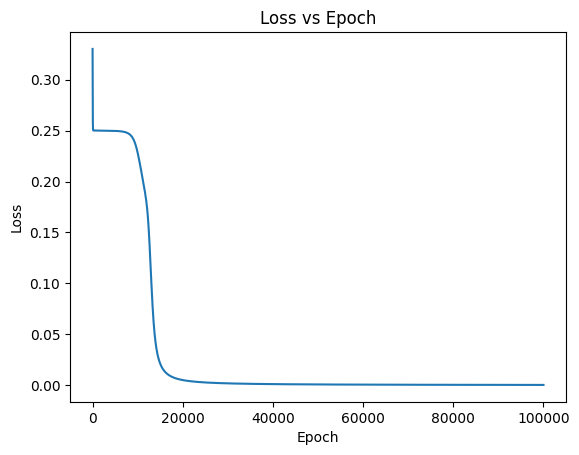

Layer 1
W = [[ 6.40349804  5.47245666]
 [-6.32562268 -5.69065367]]
b = [[ 3.2208716  -2.95132274]]
Layer 2
W = [[-9.14380734]
 [ 9.65513194]]
b = [[4.28619754]]


In [7]:
nn_xor_mse = SigmoidNN([2,2,1], x_2, x_2_xor_y, 0.1, 100000, loss_func="mse")
nn_xor_mse.train(print_epoch=10000)
nn_xor_mse.plot_loss()
nn_xor_mse.print_weights_and_biases()

Epoch 0: Loss = 0.7658478968326412, Accuracy = 0.5
Epoch 10000: Loss = 0.018496395440750373, Accuracy = 1.0
Epoch 20000: Loss = 0.006350922940511067, Accuracy = 1.0
Epoch 30000: Loss = 0.0037991317397592706, Accuracy = 1.0
Epoch 40000: Loss = 0.0027032417851668216, Accuracy = 1.0
Epoch 50000: Loss = 0.002095647794068428, Accuracy = 1.0
Epoch 60000: Loss = 0.0017099935827702049, Accuracy = 1.0
Epoch 70000: Loss = 0.0014436643176573302, Accuracy = 1.0
Epoch 80000: Loss = 0.0012487958964764504, Accuracy = 1.0
Epoch 90000: Loss = 0.0011000790985802723, Accuracy = 1.0


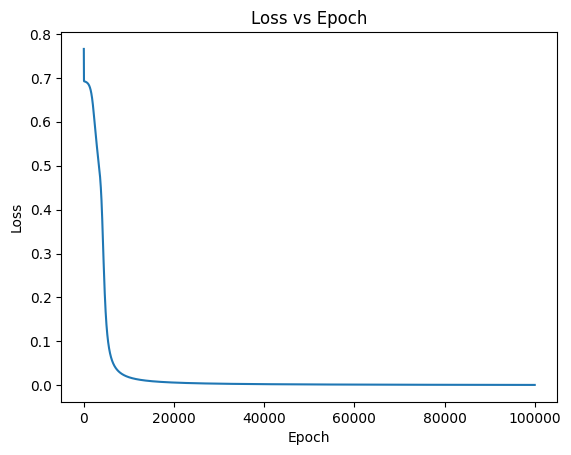

Layer 1
W = [[6.12117857 7.9528102 ]
 [6.12260868 7.9607559 ]]
b = [[-9.35259701 -3.68469989]]
Layer 2
W = [[-15.66679907]
 [ 14.86862609]]
b = [[-7.03395439]]


In [8]:
nn_xor_bce = SigmoidNN([2,2,1], x_2, x_2_xor_y, 0.1, 100000, loss_func="bce")
nn_xor_bce.train(print_epoch=10000)
nn_xor_bce.plot_loss()
nn_xor_bce.print_weights_and_biases()

Epoch 0: Loss = 0.6276877297442777, Accuracy = 0.25
Epoch 10000: Loss = 0.17123264815244796, Accuracy = 0.8125
Epoch 20000: Loss = 0.13579725810757626, Accuracy = 0.8125
Epoch 30000: Loss = 0.03365393746071442, Accuracy = 1.0
Epoch 40000: Loss = 0.0070252751770202, Accuracy = 1.0
Epoch 50000: Loss = 0.003262296864774565, Accuracy = 1.0
Epoch 60000: Loss = 0.002027265625394372, Accuracy = 1.0
Epoch 70000: Loss = 0.0014428472038973215, Accuracy = 1.0
Epoch 80000: Loss = 0.0011090475237306985, Accuracy = 1.0
Epoch 90000: Loss = 0.0008954527489281694, Accuracy = 1.0


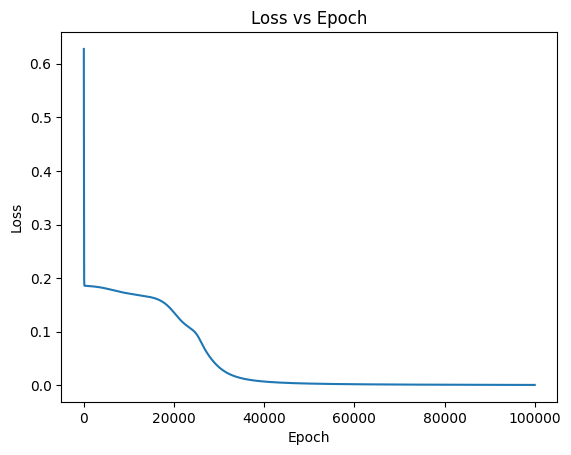

Layer 1
W = [[ 7.84876776 -7.61843136  1.60135294]
 [ 4.21914791 -3.68624058  4.68473672]
 [-3.58738134  4.28382441  4.65019301]
 [-7.44228224  8.00879302  1.60898117]]
b = [[1.74757295 1.835859   0.4260764 ]]
Layer 2
W = [[  9.83842082]
 [  9.81281954]
 [-10.55639224]]
b = [[-4.45130015]]


In [9]:
nn_pal_4_mse = SigmoidNN([4,3,1], x_4, x_4_palindrome_y, 0.1, 100000, loss_func="mse")
nn_pal_4_mse.train(print_epoch=10000)
nn_pal_4_mse.plot_loss()
nn_pal_4_mse.print_weights_and_biases()

Epoch 0: Loss = 1.6354801688897753, Accuracy = 0.25
Epoch 10000: Loss = 0.2211521968986258, Accuracy = 0.9375
Epoch 20000: Loss = 0.08979715742521395, Accuracy = 1.0
Epoch 30000: Loss = 0.05511142686048543, Accuracy = 1.0
Epoch 40000: Loss = 0.03943211118197314, Accuracy = 1.0
Epoch 50000: Loss = 0.03056239369485165, Accuracy = 1.0
Epoch 60000: Loss = 0.02487982562401396, Accuracy = 1.0
Epoch 70000: Loss = 0.020943358555851943, Accuracy = 1.0
Epoch 80000: Loss = 0.018065586643242468, Accuracy = 1.0
Epoch 90000: Loss = 0.015875315042135362, Accuracy = 1.0


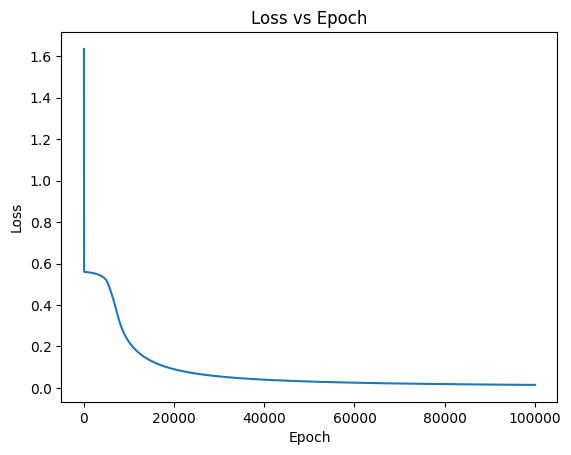

Layer 1
W = [[-1.06752287  1.310716    8.98877913]
 [ 8.93656034  1.31150769 -1.09895072]
 [ 9.04960485  1.32232822 -0.92107854]
 [-0.98216195  1.31637156  9.08429652]]
b = [[-1.30745041 -3.32292515 -1.38303772]]
Layer 2
W = [[-18.50474643]
 [ 32.25750627]
 [-18.41321739]]
b = [[11.73972707]]


In [10]:
nn_pal_4_bce = SigmoidNN([4,3,1], x_4, x_4_palindrome_y, 0.1, 100000, loss_func="bce")
nn_pal_4_bce.train(print_epoch=10000)
nn_pal_4_bce.plot_loss()
nn_pal_4_bce.print_weights_and_biases()

Epoch 0: Loss = 0.48026208227689493, Accuracy = 0.25
Epoch 10000: Loss = 0.1820086653182669, Accuracy = 0.75
Epoch 20000: Loss = 0.16896903486276155, Accuracy = 0.75
Epoch 30000: Loss = 0.16480427893839525, Accuracy = 0.75
Epoch 40000: Loss = 0.0774970509293726, Accuracy = 0.9375
Epoch 50000: Loss = 0.03449533848959531, Accuracy = 1.0
Epoch 60000: Loss = 0.020557917271901607, Accuracy = 1.0
Epoch 70000: Loss = 0.01419141168759543, Accuracy = 1.0
Epoch 80000: Loss = 0.01067815479420169, Accuracy = 1.0
Epoch 90000: Loss = 0.008490887567524866, Accuracy = 1.0
Epoch 100000: Loss = 0.0070130490613699486, Accuracy = 1.0
Epoch 110000: Loss = 0.005954295253615735, Accuracy = 1.0
Epoch 120000: Loss = 0.0051618138230811565, Accuracy = 1.0
Epoch 130000: Loss = 0.004548181832573067, Accuracy = 1.0
Epoch 140000: Loss = 0.004060046614157157, Accuracy = 1.0
Epoch 150000: Loss = 0.0036631289504175353, Accuracy = 1.0
Epoch 160000: Loss = 0.0033344621185215995, Accuracy = 1.0
Epoch 170000: Loss = 0.0030

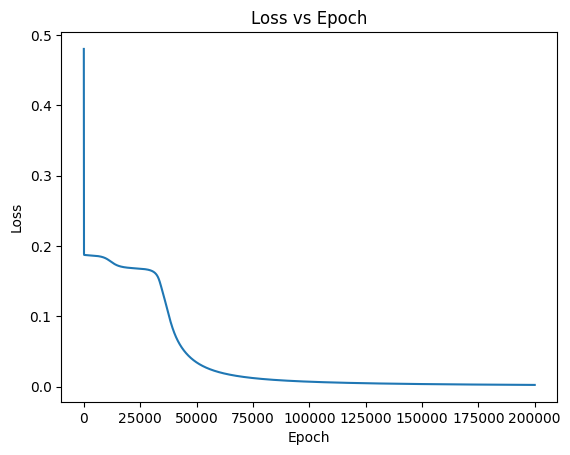

Layer 1
W = [[ 7.82030724e+00 -9.45346170e-01  1.33591798e+00]
 [-9.67201303e-01  8.01923391e+00  1.32784087e+00]
 [-1.88049923e-03  2.95655935e-03  4.80557547e-05]
 [-9.67170826e-01  8.02032167e+00  1.32786064e+00]
 [ 7.82866169e+00 -9.44952251e-01  1.33609774e+00]]
b = [[-1.03167829 -1.15357376 -3.44432632]]
Layer 2
W = [[-13.51707581]
 [-13.3678045 ]
 [ 22.75286381]]
b = [[9.4456035]]


In [17]:
nn_pal_5_mse = SigmoidNN([5,3,1], x_5, x_5_palindrome_y, 0.1, 200000, loss_func="mse")
nn_pal_5_mse.train(print_epoch=10000)
nn_pal_5_mse.plot_loss()
nn_pal_5_mse.print_weights_and_biases()

Epoch 0: Loss = 1.3476041342059408, Accuracy = 0.25
Epoch 10000: Loss = 0.02102538414921911, Accuracy = 1.0
Epoch 20000: Loss = 0.0056958377724137576, Accuracy = 1.0
Epoch 30000: Loss = 0.003217157742530215, Accuracy = 1.0
Epoch 40000: Loss = 0.002227313880682377, Accuracy = 1.0
Epoch 50000: Loss = 0.001698419709814939, Accuracy = 1.0
Epoch 60000: Loss = 0.0013703692633910127, Accuracy = 1.0
Epoch 70000: Loss = 0.0011474234246447463, Accuracy = 1.0
Epoch 80000: Loss = 0.0009862316500348718, Accuracy = 1.0
Epoch 90000: Loss = 0.0008643535255050796, Accuracy = 1.0


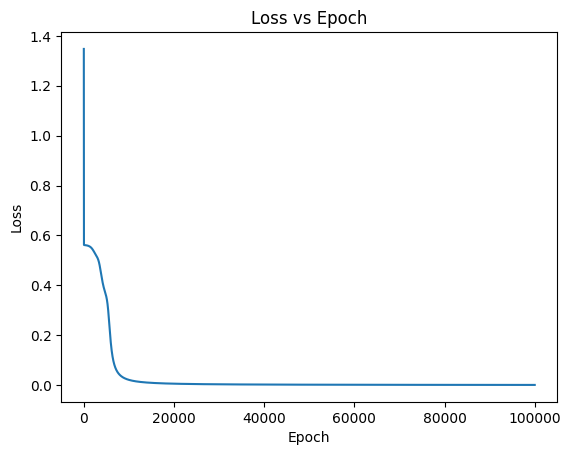

Layer 1
W = [[ 6.26402608  8.82315132  0.03004915]
 [ 4.57863685 -4.71607017 -7.83422172]
 [-0.10309579 -0.02789793  0.21539746]
 [-4.80171528  4.7312194   8.28312238]
 [ 6.16886518  8.78439046  0.51528791]]
b = [[-9.66585101 -2.49796071  3.63197422]]
Layer 2
W = [[ 16.13411436]
 [-16.65474715]
 [ 15.22560378]]
b = [[-6.98943494]]


In [12]:
nn_pal_5_bce = SigmoidNN([5,3,1], x_5, x_5_palindrome_y, 0.2, 100000, loss_func="bce")
nn_pal_5_bce.train(print_epoch=10000)
nn_pal_5_bce.plot_loss()
nn_pal_5_bce.print_weights_and_biases()

Epoch 0: Loss = 0.44223947422164955, Accuracy = 0.5
Epoch 10000: Loss = 0.24994512228909216, Accuracy = 0.5
Epoch 20000: Loss = 0.24980571897089254, Accuracy = 0.5625
Epoch 30000: Loss = 0.24727305867784416, Accuracy = 0.6875
Epoch 40000: Loss = 0.07545835305861442, Accuracy = 0.9375
Epoch 50000: Loss = 0.059091308214631835, Accuracy = 0.9375
Epoch 60000: Loss = 0.05527205354561062, Accuracy = 0.9375
Epoch 70000: Loss = 0.0535895905228192, Accuracy = 0.9375
Epoch 80000: Loss = 0.05263377533367788, Accuracy = 0.9375
Epoch 90000: Loss = 0.051999524109279015, Accuracy = 0.9375
Epoch 100000: Loss = 0.05152531379661229, Accuracy = 0.9375
Epoch 110000: Loss = 0.050889872039938056, Accuracy = 0.9375
Epoch 120000: Loss = 0.021225875606427805, Accuracy = 1.0
Epoch 130000: Loss = 0.0030972462420359474, Accuracy = 1.0
Epoch 140000: Loss = 0.0015568554770828268, Accuracy = 1.0
Epoch 150000: Loss = 0.0010200951488350976, Accuracy = 1.0
Epoch 160000: Loss = 0.0007468638481662247, Accuracy = 1.0
Epoc

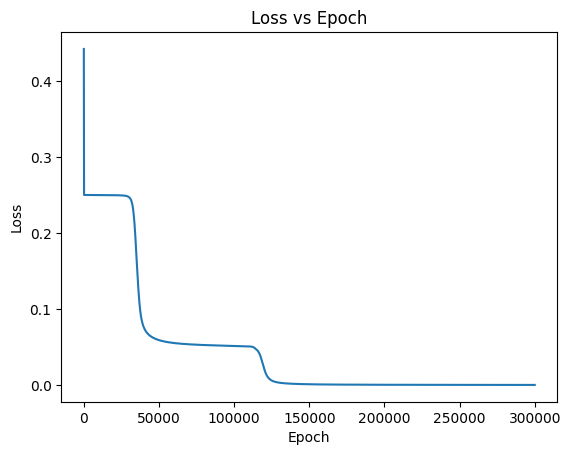

Layer 1
W = [[ 6.12776107  6.90695391  3.62097501  7.16783745 -5.39148105]
 [ 6.07233637  6.07068865  3.27170365 -3.15630987  7.48992305]
 [ 7.55149945  1.6657353   3.07780041  6.32624081  7.04317837]
 [ 7.42369342  2.20425646  3.01281699  4.81962598  6.0072672 ]]
b = [[ -9.23102707  -7.67821267 -11.69594521  -4.38804949  -3.70147219]]
Layer 2
W = [[ 15.91607852]
 [-10.48357144]
 [ 12.89131108]
 [ -7.92168164]
 [ -9.30064751]]
b = [[5.48506168]]


In [16]:
nn_even_4 = SigmoidNN([4,5,1], x_4, x_4_even_parity_y, 0.2, 300000, loss_func="mse")
nn_even_4.train(print_epoch=10000)
nn_even_4.plot_loss()
nn_even_4.print_weights_and_biases()

Epoch 0: Loss = 0.48099768307369184, Accuracy = 0.5
Epoch 10000: Loss = 0.2500161000751507, Accuracy = 0.59375
Epoch 20000: Loss = 0.25000314149841896, Accuracy = 0.625
Epoch 30000: Loss = 0.24999747580143206, Accuracy = 0.625
Epoch 40000: Loss = 0.2499939968983444, Accuracy = 0.53125
Epoch 50000: Loss = 0.2499911449685222, Accuracy = 0.5
Epoch 60000: Loss = 0.24998826249947284, Accuracy = 0.46875
Epoch 70000: Loss = 0.2499849476578796, Accuracy = 0.46875
Epoch 80000: Loss = 0.24998083219230657, Accuracy = 0.5
Epoch 90000: Loss = 0.2499754577700236, Accuracy = 0.46875
Epoch 100000: Loss = 0.24996814274425508, Accuracy = 0.4375
Epoch 110000: Loss = 0.24995775572441978, Accuracy = 0.4375
Epoch 120000: Loss = 0.2499422400894134, Accuracy = 0.4375
Epoch 130000: Loss = 0.24991746992549307, Accuracy = 0.4375
Epoch 140000: Loss = 0.24987406983928506, Accuracy = 0.5
Epoch 150000: Loss = 0.24978668469896953, Accuracy = 0.5
Epoch 160000: Loss = 0.24956553200323017, Accuracy = 0.5
Epoch 170000: L

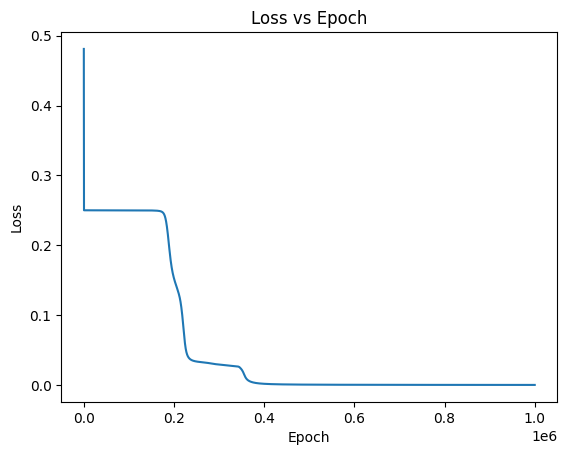

Layer 1
W = [[ 4.59320044  2.72729984  4.80863871  7.14550606  5.26137332  1.635745
   1.59784243]
 [ 4.5997747   2.72548984  4.8161268   7.13641969  5.25246971  1.47874195
   1.57879586]
 [ 5.17945935  2.78517665  5.28594975  5.82468082 -3.01772426 -0.96477153
   5.67810548]
 [ 4.5597886   2.72148964  4.80974337  7.16525545  5.13655252  1.37294452
   1.61790188]
 [ 4.60588209  2.72451815  4.81908551  7.06648372  5.26210793  1.3918939
   1.54517088]]
b = [[-11.34996557 -12.50987175 -16.64544517 -10.57657085  -2.93889731
    0.06777899  -2.20243905]]
Layer 2
W = [[-11.6933728 ]
 [-14.76848384]
 [ 15.26025409]
 [ 15.30708769]
 [ -8.23826721]
 [  1.93768798]
 [ -8.98492642]]
b = [[4.01630228]]


In [14]:
nn_even_5 = SigmoidNN([5,7,1], x_5, x_5_even_parity_y, 0.1, 1000000, loss_func="mse")
nn_even_5.train(print_epoch=10000)
nn_even_5.plot_loss()
nn_even_5.print_weights_and_biases()